In [75]:
import backtrader as bt
import pandas as pd
import duckdb
from backtrader.utils.date import num2date      # 推荐写法


etfs = ['561300', '159726', '515100', '513500',
        '518880', '164824', '159985', '513330', '513100',
        '513030', '513520']
start_date = '2022-07-01'
end_date = '2025-08-13'

con = duckdb.connect(database=':memory:', read_only=False) 
symbols_tuple = tuple(etfs)

path = '../dataset/data/etf_prices/**/data.parquet'

query = f"""
SELECT
    date,
    open,
    high,
    low,
    close,
    volume,
    turnover,
    symbol
FROM read_parquet('{path}')
WHERE symbol IN {symbols_tuple}
AND date BETWEEN '{start_date}' AND '{end_date}'
ORDER BY symbol, date
"""

df_all = con.execute(query).df()
con.close()

# 类型转换
df_all['date'] = pd.to_datetime(df_all['date'])
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
df_all[numeric_cols] = df_all[numeric_cols].astype(float)
df_all.tail(10)

,date,open,high,low,close,volume,turnover,symbol
8327,2025-07-31,0.888,0.888,0.869,0.871,1462362.0,127793264.0,561300
8328,2025-08-01,0.871,0.874,0.864,0.868,259541.0,22583882.0,561300
8329,2025-08-04,0.866,0.873,0.861,0.871,285860.0,24808169.0,561300
8330,2025-08-05,0.876,0.880,0.871,0.878,299286.0,26168527.0,561300
8331,2025-08-06,0.877,0.883,0.877,0.882,103807.0,9139153.0,561300
8332,2025-08-07,0.882,0.884,0.877,0.882,356188.0,31385226.0,561300
8333,2025-08-08,0.882,0.885,0.879,0.882,135361.0,11931573.0,561300
8334,2025-08-11,0.880,0.887,0.880,0.884,230844.0,20411420.0,561300
8335,2025-08-12,0.883,0.890,0.882,0.888,358191.0,31773432.0,561300
8336,2025-08-13,0.888,0.900,0.888,0.897,266841.0,23871007.0,561300


In [80]:
from sklearn.linear_model import LinearRegression
import numpy as np

def calculate_score(data: np.ndarray) -> float:
    """计算强弱得分"""
    x = np.arange(1, len(data) + 1).reshape(-1, 1)
    y = data / data[0]  # 归一化
    reg = LinearRegression().fit(x, y)
    slope = reg.coef_[0]
    r2 = reg.score(x, y)
    return slope * r2


class MomentumTopN(bt.Strategy):
    params = (
        ('lookback_period', 20),      # 回归窗口
        ('ma_period', 120),           # 均线周期
        ('topn', 4),                  # 持仓数量
        ('rebalance_days', 5),        # 调仓频率
        ('lot_size', 100),            # 每手100股
        ('debug', False),              # 是否打印订单信息
    )

    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = dict(
                ma=bt.indicators.SimpleMovingAverage(d.close, period=self.p.ma_period)
            )
        self.counter = 0
        self.max_equity = 0

    def next(self):
        self.counter += 1
        if self.counter % self.p.rebalance_days != 0:
            return

        # === 1. 计算得分，选出 TopN ===
        eligible = []
        scores = {}

        for d in self.datas:
            if len(d) >= max(self.p.lookback_period, self.p.ma_period):
                close_array = np.array(d.get(size=self.p.lookback_period))
                score = calculate_score(close_array)
                scores[d] = score
                eligible.append(d)

        eligible.sort(key=lambda d: scores[d], reverse=True)
        top = eligible[:self.p.topn]

        if not top:
            return

        # === 2. 每只股票分 1/N 的总资产 ===
        total_value = self.broker.getvalue() 
        target_per_stock = total_value / len(top)
        
        targets = {}
        for d in self.datas:
            if d in top:
                target_size = target_per_stock / d.close[0]
                target_size = int(target_size // self.p.lot_size) * self.p.lot_size
                target_size = max(0, int(target_size))
            else:
                target_size = 0  # 清仓
            targets[d] = target_size
    
        # === 3. 先卖出：对所有 data，如果 target < current，先卖出 ===
        for d in self.datas:
            pos = self.getposition(d).size
            target_size = targets[d]
            if pos > target_size:
                # 先卖出多余的（包括清仓）
                self.order_target_size(d, target_size)
    
        # === 4. 再买入：如果 target > current，后买入 ===
        for d in self.datas:
            pos = self.getposition(d).size
            target_size = targets[d]
            if pos < target_size:
                # 后买入（现金已由上一步卖出释放）
                self.order_target_size(d, target_size)
    

    def notify_order(self, order):
        order_time = num2date(order.data.datetime[0]).strftime('%Y-%m-%d %H:%M:%S')
        if order.status in [order.Completed]:
            direction = '买入' if order.isbuy() else '卖出'
            size = order.executed.size
            asset_name = order.data._name
            if self.p.debug:
                print(f"✅ {order_time} 成交 | {direction} {asset_name} {size} 股 价格: {order.executed.price}")
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if self.p.debug:
                print(f"❌ {order_time} 订单失败 | {order.data._name} 被 {order.Status[order.status]}")

In [93]:
# ------------------------------------------------------------------
# 2. 构造 cerebro 并循环添加每个 ETF 的数据
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

for symbol in etfs:
    # 取出当前标的
    df_sym = df_all[df_all['symbol'] == symbol].copy()

    # 确保按日期排序
    df_sym.sort_values('date', inplace=True)

    # 设置 datetime 为索引
    df_sym.set_index('date', inplace=True)

    # 删除多余的 symbol 列
    df_sym.drop(columns=['symbol'], inplace=True)

    # 缺失值前向填充（如有停牌）
    df_sym = df_sym.ffill()

    # 构建 backtrader 数据源
    data = bt.feeds.PandasData(
        dataname=df_sym,
        name=symbol,
        # 如果列名与默认一致，无需额外映射
    )
    cerebro.adddata(data)

## 回测参数
params = {'lookback_period': 40, 'topn': 4, 'rebalance_days': 5, 'debug': False }
cerebro.addstrategy(MomentumTopN, **params)
cerebro.broker.setcommission(commission=0.0005)
cerebro.broker.set_slippage_perc(0.002)  # 0.1% 滑点
cerebro.broker.set_coc(True)

cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.broker.setcash(100000) 

# ------------------------------------------------------------------
# 4. 运行回测
# ------------------------------------------------------------------
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

期望最终资金: 1.04x
亏损概率: 28.10%
95% 置信区间: [0.90, 1.17]


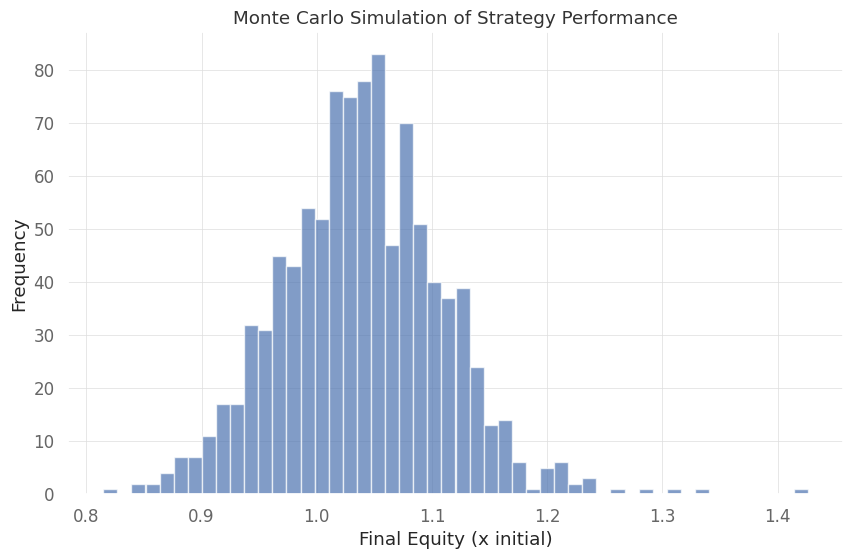

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# 蒙特卡洛重采样
num_simulations = 1000
num_trades = 50
final_equity = []

for _ in range(num_simulations):
    sim_returns = np.random.choice(returns, size=num_trades, replace=True)
    equity_curve = (1 + sim_returns).cumprod()
    final_equity.append(equity_curve[-1])

final_equity = np.array(final_equity)

# 结果分析
print(f"期望最终资金: {final_equity.mean():.2f}x")
print(f"亏损概率: {np.mean(final_equity < 1):.2%}")
print(f"95% 置信区间: [{np.percentile(final_equity, 2.5):.2f}, {np.percentile(final_equity, 97.5):.2f}]")

# 可视化
plt.hist(final_equity, bins=50, alpha=0.7)
plt.title("Monte Carlo Simulation of Strategy Performance")
plt.xlabel("Final Equity (x initial)")
plt.ylabel("Frequency")
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2022-07-01
End Period                 2025-08-13
Risk-Free Rate             0.0%
Time in Market             84.0%

Cumulative Return          72.02%
CAGR﹪                     19.76%

Sharpe                     1.31
Prob. Sharpe Ratio         98.69%
Smart Sharpe               1.29
Sortino                    1.91
Smart Sortino              1.87
Sortino/√2                 1.35
Smart Sortino/√2           1.33
Omega                      1.29

Max Drawdown               -13.3%
Max DD Date                2024-08-05
Max DD Period Start        2024-07-10
Max DD Period End          2024-11-06
Longest DD Days            120
Volatility (ann.)          14.53%
Calmar                     1.49
Skew                       -0.52
Kurtosis                   5.47

Expected Daily %           0.07%
Expected Monthly %         1.44%
Expected Yearly %          14.52%
Kelly Criterion            12.29%
Risk of Ruin

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-10,2024-08-05,2024-11-06,120,-13.297495,-11.806348
2,2025-03-20,2025-04-07,2025-04-21,33,-7.993427,-6.563034
3,2024-05-21,2024-06-17,2024-07-08,49,-6.586917,-6.481824
4,2024-01-24,2024-01-26,2024-02-27,35,-6.564086,-6.045445
5,2023-09-18,2023-11-10,2023-12-19,93,-6.379042,-6.162436


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


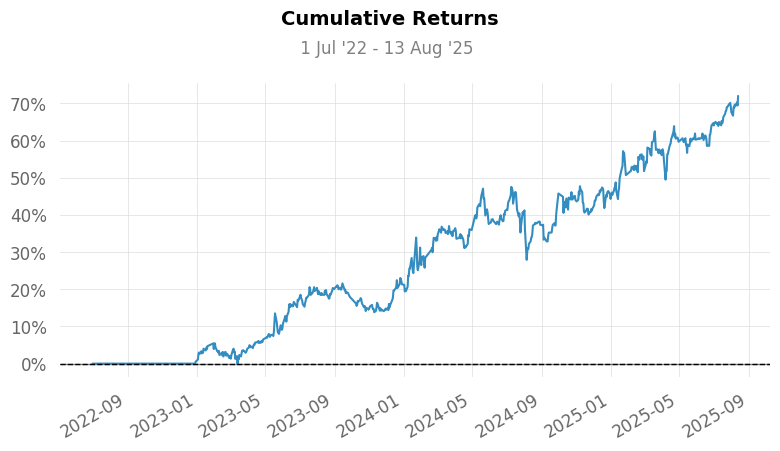

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


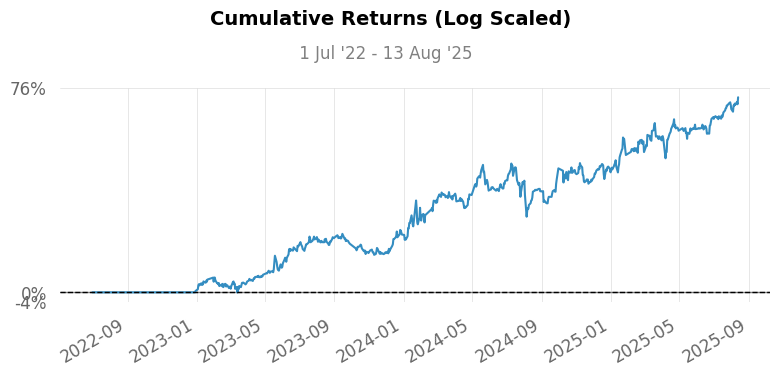

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


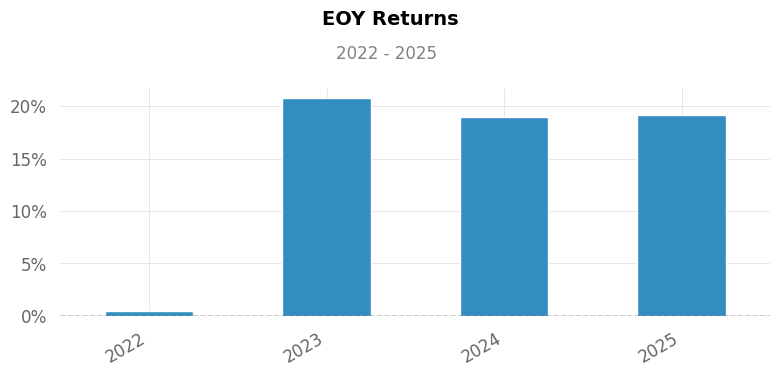

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


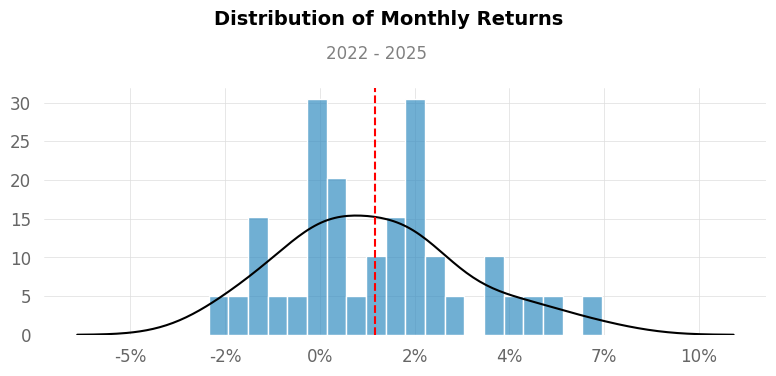

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


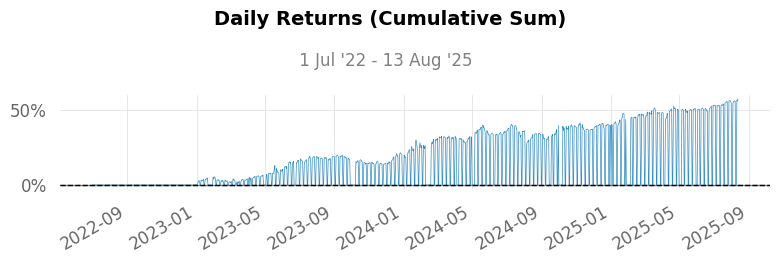

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


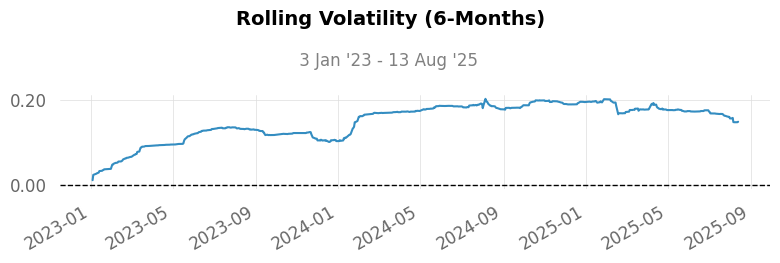

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


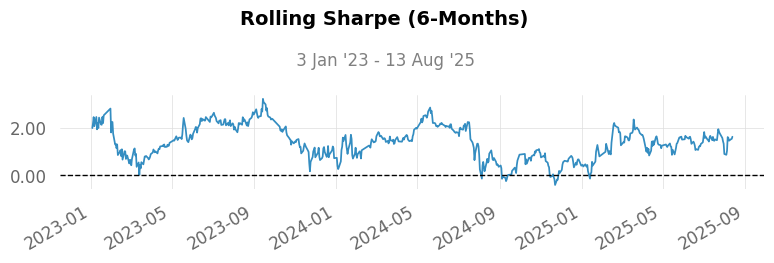

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


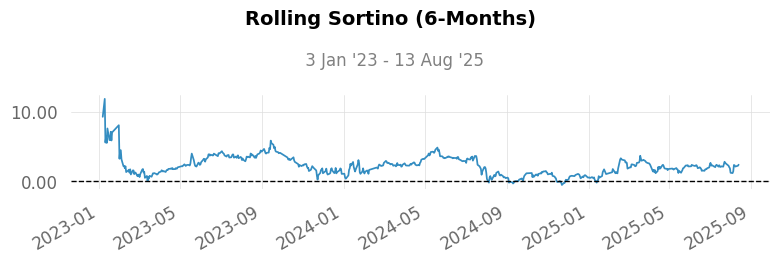

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


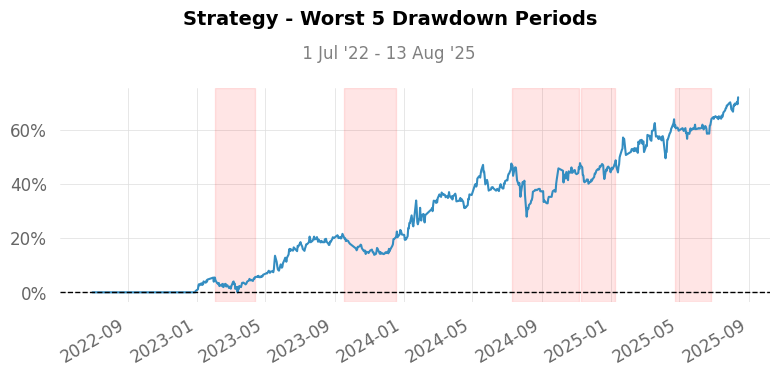

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


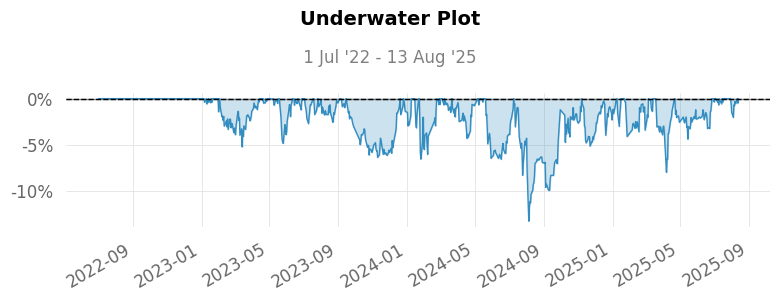

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


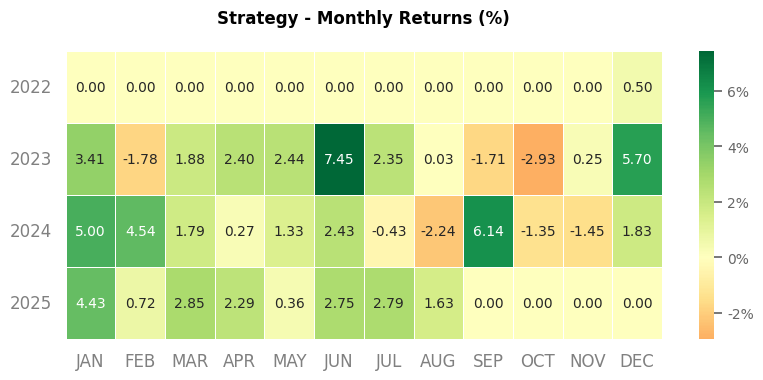

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


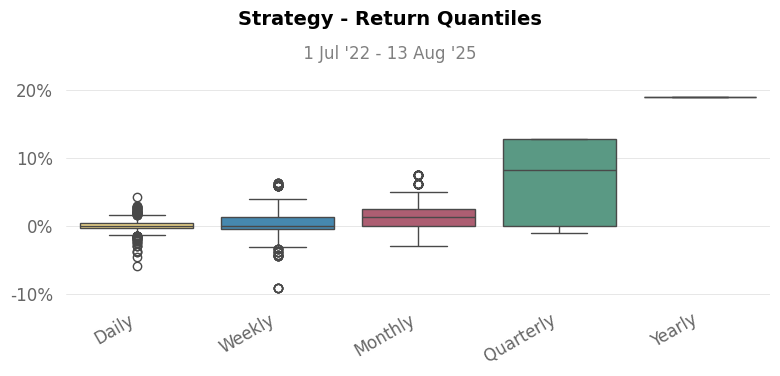

In [95]:
import quantstats as qs

qs.reports.full(returns)

In [89]:
import optuna


def objective(trial):
    params = dict(
        lookback_period = trial.suggest_int('lookback_period', 10, 60, step=5),      # 回归/动量窗口：5到60天
        topn            = trial.suggest_int('topn', 3, 6),                 # 每期持仓数：1~10只
        rebalance_days  = trial.suggest_int('rebalance_days', 3, 10),       # 调仓间隔：1~20天（如每周5天）
    )

    
    cerebro = bt.Cerebro()
    for symbol in etfs:
        # 取出当前标的
        df_sym = df_all[df_all['symbol'] == symbol].copy()
    
        # 确保按日期排序
        df_sym.sort_values('date', inplace=True)
    
        # 设置 datetime 为索引
        df_sym.set_index('date', inplace=True)
    
        # 删除多余的 symbol 列
        df_sym.drop(columns=['symbol'], inplace=True)
    
        # 缺失值前向填充（如有停牌）
        df_sym = df_sym.ffill()
    
        # 构建 backtrader 数据源
        data = bt.feeds.PandasData(
            dataname=df_sym,
            name=symbol,
            # 如果列名与默认一致，无需额外映射
        )
        cerebro.adddata(data)
        
    cerebro.broker.setcash(100_000)
    cerebro.broker.setcommission(commission=0.0005)
    cerebro.broker.set_coc(True)


    # 把参数传给策略
    cerebro.addstrategy(MomentumTopN, **params)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    results = cerebro.run()
    sharpe = results[0].analyzers.sharpe.get_analysis().get('sharperatio', 0)
    return sharpe if sharpe else 0.0   # Optuna 只接受最大化

# ------------------- 运行优化 -------------------
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    print("最佳参数：", study.best_params)
    print("最佳夏普：", study.best_value)

[I 2025-08-25 23:06:33,602] A new study created in memory with name: no-name-2c93d95b-7616-4bce-97fe-c4fdddc0b7e1


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 23:06:34,707] Trial 0 finished with value: 1.4348889565363707 and parameters: {'lookback_period': 45, 'topn': 3, 'rebalance_days': 9}. Best is trial 0 with value: 1.4348889565363707.
[I 2025-08-25 23:06:36,270] Trial 1 finished with value: 1.5641303905751958 and parameters: {'lookback_period': 15, 'topn': 3, 'rebalance_days': 4}. Best is trial 1 with value: 1.5641303905751958.
[I 2025-08-25 23:06:37,365] Trial 2 finished with value: 1.4410067841441028 and parameters: {'lookback_period': 60, 'topn': 4, 'rebalance_days': 7}. Best is trial 1 with value: 1.5641303905751958.
[I 2025-08-25 23:06:38,898] Trial 3 finished with value: 1.5886321766103306 and parameters: {'lookback_period': 30, 'topn': 4, 'rebalance_days': 5}. Best is trial 3 with value: 1.5886321766103306.
[I 2025-08-25 23:06:40,258] Trial 4 finished with value: 1.5756026915664465 and parameters: {'lookback_period': 25, 'topn': 6, 'rebalance_days': 5}. Best is trial 3 with value: 1.5886321766103306.
[I 2025-08-25 2